In [9]:
import os, torch

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["HF_HOME"] = "/kaggle/working/hf_cache"

# Đường dẫn dữ liệu
DATA_DIR   = "/kaggle/input/uit-data-nhatnam12"
TRAIN_XLSX = os.path.join(DATA_DIR, "train_nor_811.xlsx")
VALID_XLSX = os.path.join(DATA_DIR, "valid_nor_811.xlsx")
TEST_XLSX  = os.path.join(DATA_DIR, "test_nor_811.xlsx")

# Đường dẫn output cho thí nghiệm mBERT "no_other"
OUT_DIR   = "/kaggle/working/outputs_mbert_vsmec_no_other"
PLOTS_DIR = os.path.join(OUT_DIR, "plots")
BEST_DIR  = os.path.join(OUT_DIR, "best_model")

for d in [OUT_DIR, PLOTS_DIR, BEST_DIR]:
    os.makedirs(d, exist_ok=True)

print("GPUs:", torch.cuda.device_count())
print(
    "Files exist:",
    os.path.exists(TRAIN_XLSX),
    os.path.exists(VALID_XLSX),
    os.path.exists(TEST_XLSX),
)


GPUs: 2
Files exist: True True True


In [10]:
import re, json, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import Dataset

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    set_seed,
)

from IPython.display import display

# Regex & chuẩn hoá
URL_RE = re.compile(r"(https?://\S+|www\.\S+)")
MULTISPACE_RE = re.compile(r"\s+")

def normalize_text(text: str) -> str:
    if text is None:
        return ""
    text = unicodedata.normalize("NFC", str(text))
    text = URL_RE.sub(" <url> ", text)
    text = MULTISPACE_RE.sub(" ", text).strip()
    return text

def read_xlsx(path: str) -> pd.DataFrame:
    return pd.read_excel(path, engine="openpyxl")

def detect_cols(df: pd.DataFrame):
    cols_lower = [c.lower() for c in df.columns]
    text_candidates  = ["sentence","text","comment","content","review","utterance"]
    label_candidates = ["emotion","label","labels","class","category"]

    text_col = next((df.columns[i] for i,c in enumerate(cols_lower) if c in text_candidates), None)
    label_col = next((df.columns[i] for i,c in enumerate(cols_lower) if c in label_candidates), None)

    # fallback nếu không tìm thấy
    if text_col is None:
        obj_cols = [c for c in df.columns if df[c].dtype == "object"]
        avg_len = {c: df[c].astype(str).str.len().mean() for c in obj_cols}
        text_col = max(avg_len, key=avg_len.get)

    if label_col is None:
        cand = []
        for c in df.columns:
            if df[c].dtype == "object":
                nunq = df[c].nunique()
                if 2 <= nunq <= 50:
                    cand.append((c, nunq))
        label_col = sorted(cand, key=lambda x: x[1])[0][0]

    return text_col, label_col

def prep_df(df: pd.DataFrame, text_col: str, label_col: str) -> pd.DataFrame:
    out = df[[text_col, label_col]].copy()
    out.columns = ["text", "label"]
    out["text"]  = out["text"].astype(str)
    out["label"] = out["label"].astype(str)
    return out


In [11]:
# Plot phân bố nhãn
def plot_label_distribution(df: pd.DataFrame, split_name: str, label_list, out_dir: str):
    os.makedirs(out_dir, exist_ok=True)
    counts = df["label"].value_counts().reindex(label_list, fill_value=0)

    plt.figure(figsize=(8, 4))
    plt.bar(counts.index, counts.values)
    plt.title(f"Label distribution - {split_name}")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    out_path = os.path.join(out_dir, f"label_dist_{split_name}.png")
    plt.savefig(out_path)
    plt.show()
    plt.close()

    print(f"✅ Saved label distribution for {split_name} to:", out_path)

# Metrics cho Trainer
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": float(accuracy_score(labels, preds)),
        "macro_f1": float(f1_score(labels, preds, average="macro", zero_division=0)),
        "weighted_f1": float(f1_score(labels, preds, average="weighted", zero_division=0)),
    }

# Plot loss / metrics
def plot_curves(log_history, out_dir):
    os.makedirs(out_dir, exist_ok=True)

    train_steps, train_loss = [], []
    eval_epochs, eval_loss = [], []
    eval_acc, eval_macro, eval_weighted = [], [], []

    for item in log_history:
        if "loss" in item and "eval_loss" not in item:
            train_steps.append(item.get("step", len(train_steps)+1))
            train_loss.append(item["loss"])
        if "eval_loss" in item:
            eval_epochs.append(item.get("epoch", len(eval_epochs)+1))
            eval_loss.append(item["eval_loss"])
            eval_acc.append(item.get("eval_accuracy"))
            eval_macro.append(item.get("eval_macro_f1"))
            eval_weighted.append(item.get("eval_weighted_f1"))

    # Training loss
    plt.figure()
    if train_loss:
        plt.plot(train_steps, train_loss, label="train_loss")
    plt.xlabel("step"); plt.ylabel("loss"); plt.title("Training loss")
    plt.legend(); plt.tight_layout()
    train_loss_path = os.path.join(out_dir, "train_loss.png")
    plt.savefig(train_loss_path)
    plt.show()
    plt.close()

    # Eval loss
    plt.figure()
    if eval_loss:
        plt.plot(eval_epochs, eval_loss, label="eval_loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Eval loss")
    plt.legend(); plt.tight_layout()
    eval_loss_path = os.path.join(out_dir, "eval_loss.png")
    plt.savefig(eval_loss_path)
    plt.show()
    plt.close()

    # Eval metrics
    plt.figure()
    if any(v is not None for v in eval_acc):
        plt.plot(eval_epochs, eval_acc, label="eval_accuracy")
    if any(v is not None for v in eval_macro):
        plt.plot(eval_epochs, eval_macro, label="eval_macro_f1")
    if any(v is not None for v in eval_weighted):
        plt.plot(eval_epochs, eval_weighted, label="eval_weighted_f1")
    plt.xlabel("epoch"); plt.ylabel("score"); plt.title("Eval metrics")
    plt.legend(); plt.tight_layout()
    eval_metrics_path = os.path.join(out_dir, "eval_metrics.png")
    plt.savefig(eval_metrics_path)
    plt.show()
    plt.close()

# Confusion matrix
def plot_confmat_normalized(y_true, y_pred, labels, out_path):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=(8,8))
    disp.plot(values_format=".2f", cmap=None, ax=plt.gca(), colorbar=True)
    plt.title("Normalized Confusion Matrix (normalize=true)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()
    plt.close()

# Per-class F1
def plot_per_class_f1(y_true, y_pred, labels, out_path):
    f1s = f1_score(y_true, y_pred, average=None, zero_division=0)
    plt.figure(figsize=(10,4))
    plt.bar(labels, f1s)
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1.0)
    plt.title("Per-class F1 (test)")
    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()
    plt.close()

# Hàm infer 1 câu với mBERT
@torch.inference_mode()
def infer_mbert(text, model, tokenizer, id2label, max_length=128, device=None):
    model.eval()
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    clean = normalize_text(text)
    inp = tokenizer(clean, truncation=True, max_length=max_length, return_tensors="pt").to(device)
    out = model(**inp)
    probs = torch.softmax(out.logits, dim=-1).squeeze(0).detach().cpu().numpy()
    pred_id = int(np.argmax(probs))
    return {
        "input": text,
        "normalized": clean,
        "pred_label": id2label[pred_id],
        "probs": {id2label[i]: float(probs[i]) for i in range(len(probs))}
    }

# Hàm in các mẫu dự đoán sai
def check_wrong(df: pd.DataFrame, n: int = 20, random: bool = False):
    wrong = df[df["is_correct"] == False]

    if wrong.empty:
        print("✅ Không có mẫu nào bị dự đoán sai.")
        return

    if random:
        wrong = wrong.sample(min(n, len(wrong)), random_state=42)
    else:
        wrong = wrong.head(n)

    for _, row in wrong.iterrows():
        text_show = row["text"]
        print(text_show)
        print(f"Predicted: ({row['pred_label']}) --vs-- Real label: ({row['label']})")
        print("-" * 50)


Detected columns -> text: Sentence | label: Emotion
Sizes (full, with Other): 5548 686 693


,text,label
0,cho mình xin bài nhạc tên là gì với ạ,Other
1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,Disgust
2,lo học đi . yêu đương lol gì hay lại thích học...,Disgust
3,uớc gì sau này về già vẫn có thể như cụ này :)),Enjoyment
4,mỗi lần có video của con là cứ coi đi coi lại ...,Enjoyment


All labels (full): ['Anger', 'Disgust', 'Enjoyment', 'Fear', 'Other', 'Sadness', 'Surprise']


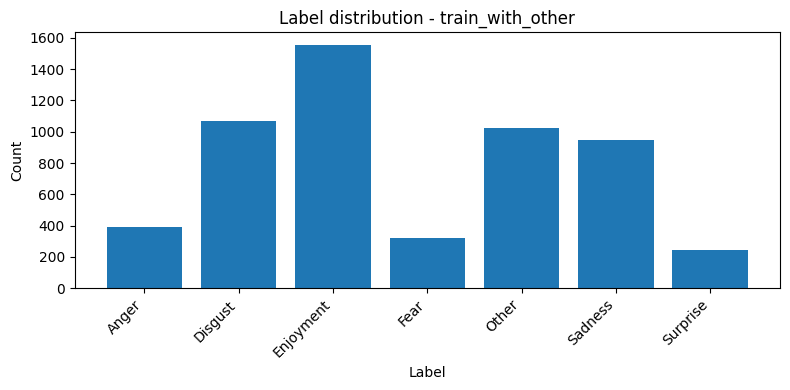

✅ Saved label distribution for train_with_other to: /kaggle/working/outputs_mbert_vsmec_no_other/plots/label_dist_train_with_other.png


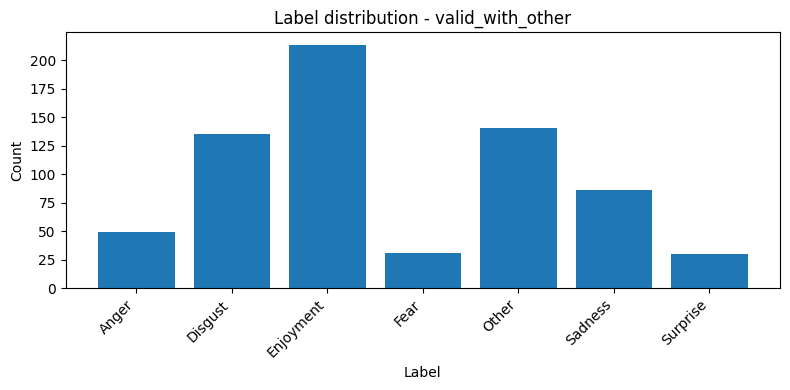

✅ Saved label distribution for valid_with_other to: /kaggle/working/outputs_mbert_vsmec_no_other/plots/label_dist_valid_with_other.png


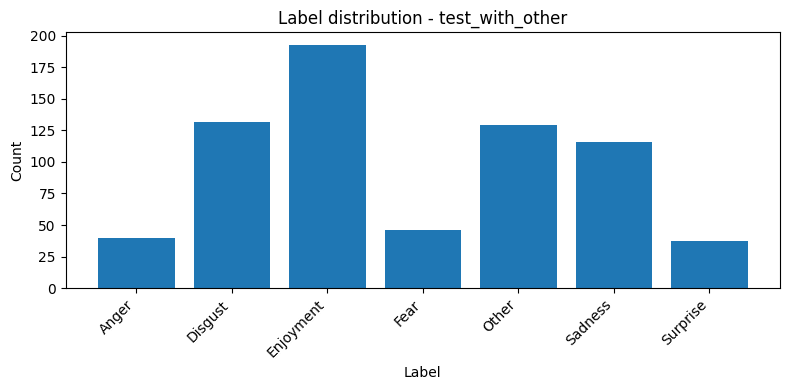

✅ Saved label distribution for test_with_other to: /kaggle/working/outputs_mbert_vsmec_no_other/plots/label_dist_test_with_other.png


In [12]:
# Đọc dataset gốc (chưa bỏ Other)
train_raw = read_xlsx(TRAIN_XLSX)
valid_raw = read_xlsx(VALID_XLSX)
test_raw  = read_xlsx(TEST_XLSX)

# Detect cột text / label
text_col, label_col = detect_cols(train_raw)
print("Detected columns -> text:", text_col, "| label:", label_col)

# Chuẩn hoá về 2 cột: text, label
train_full = prep_df(train_raw, text_col, label_col)
valid_full = prep_df(valid_raw, text_col, label_col)
test_full  = prep_df(test_raw,  text_col, label_col)

print("Sizes (full, with Other):", len(train_full), len(valid_full), len(test_full))
display(train_full.head())

# Label list đầy đủ (gồm cả Other)
label_list_full = sorted(train_full["label"].unique().tolist())
print("All labels (full):", label_list_full)

# Plot phân bố nhãn gốc (vẫn còn Other)
plot_label_distribution(train_full, "train_with_other", label_list_full, PLOTS_DIR)
plot_label_distribution(valid_full, "valid_with_other", label_list_full, PLOTS_DIR)
plot_label_distribution(test_full,  "test_with_other",  label_list_full, PLOTS_DIR)


train: dropped 1021 samples with labels {'other'}, remain 4527
valid: dropped 141 samples with labels {'other'}, remain 545
test: dropped 129 samples with labels {'other'}, remain 564
Sizes after dropping Other: 4527 545 564


,text,label
0,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,Disgust
1,lo học đi . yêu đương lol gì hay lại thích học...,Disgust
2,uớc gì sau này về già vẫn có thể như cụ này :)),Enjoyment
3,mỗi lần có video của con là cứ coi đi coi lại ...,Enjoyment
4,thằng kia sao mày bắt vợ với bồ tao dọn thế ki...,Anger


Labels (no Other): ['Anger', 'Disgust', 'Enjoyment', 'Fear', 'Sadness', 'Surprise']


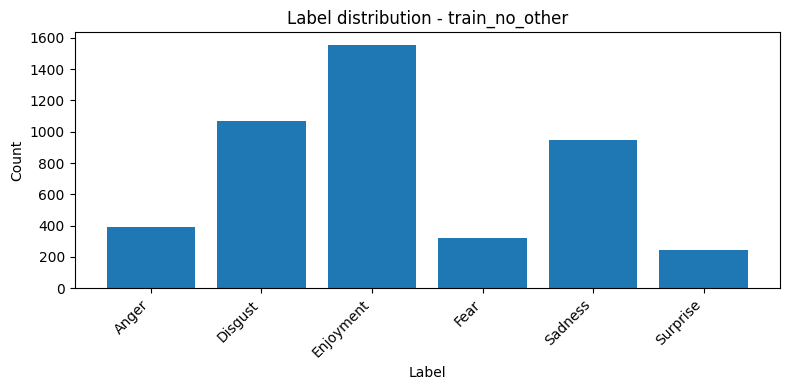

✅ Saved label distribution for train_no_other to: /kaggle/working/outputs_mbert_vsmec_no_other/plots/label_dist_train_no_other.png


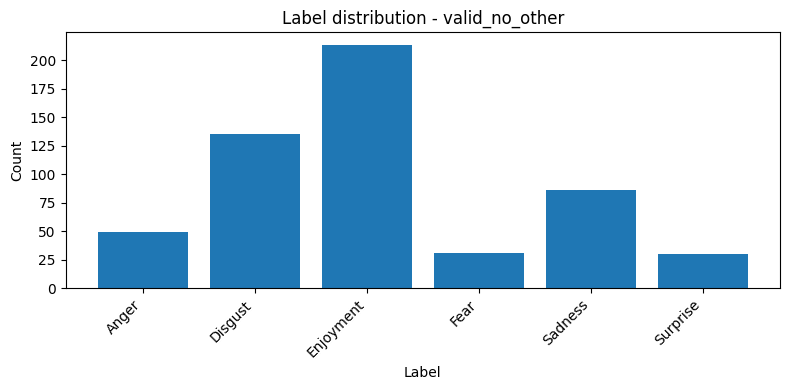

✅ Saved label distribution for valid_no_other to: /kaggle/working/outputs_mbert_vsmec_no_other/plots/label_dist_valid_no_other.png


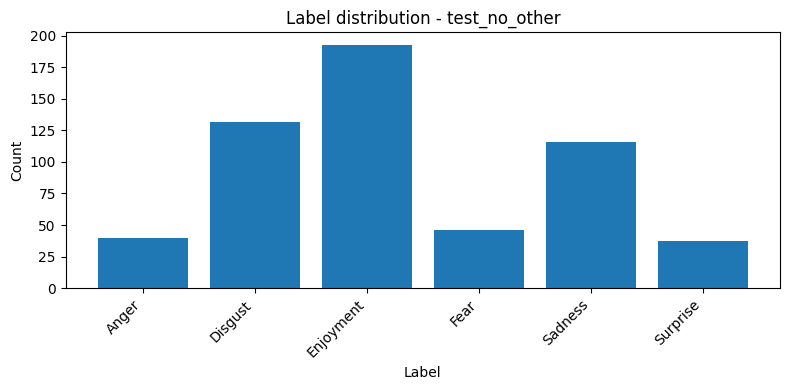

✅ Saved label distribution for test_no_other to: /kaggle/working/outputs_mbert_vsmec_no_other/plots/label_dist_test_no_other.png


In [13]:
# Bỏ nhãn Other (case-insensitive)
DROP_LABELS = {"other"}

def drop_labels(df: pd.DataFrame, split_name: str) -> pd.DataFrame:
    before = len(df)
    df = df[~df["label"].str.lower().isin(DROP_LABELS)].reset_index(drop=True)
    dropped = before - len(df)
    print(f"{split_name}: dropped {dropped} samples with labels {DROP_LABELS}, remain {len(df)}")
    return df

train_df = drop_labels(train_full, "train")
valid_df = drop_labels(valid_full, "valid")
test_df  = drop_labels(test_full,  "test")

print("Sizes after dropping Other:", len(train_df), len(valid_df), len(test_df))
display(train_df.head())

# Label list mới (không còn Other)
label_list = sorted(train_df["label"].unique().tolist())
print("Labels (no Other):", label_list)

# Plot phân bố nhãn sau khi bỏ Other
plot_label_distribution(train_df, "train_no_other", label_list, PLOTS_DIR)
plot_label_distribution(valid_df, "valid_no_other", label_list, PLOTS_DIR)
plot_label_distribution(test_df,  "test_no_other",  label_list, PLOTS_DIR)


In [14]:
# Mapping nhãn
label2id = {l:i for i,l in enumerate(label_list)}
id2label = {i:l for l,i in label2id.items()}

for df in [train_df, valid_df, test_df]:
    df["labels"] = df["label"].map(label2id)

# Chuẩn hoá text cho mBERT
def add_text_clean(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["text_clean"] = df["text"].apply(normalize_text)
    return df

train_df = add_text_clean(train_df)
valid_df = add_text_clean(valid_df)
test_df  = add_text_clean(test_df)

print("Labels (final):", label_list)
display(train_df.head())


Labels (final): ['Anger', 'Disgust', 'Enjoyment', 'Fear', 'Sadness', 'Surprise']


,text,label,labels,text_clean
0,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,Disgust,1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
1,lo học đi . yêu đương lol gì hay lại thích học...,Disgust,1,lo học đi . yêu đương lol gì hay lại thích học...
2,uớc gì sau này về già vẫn có thể như cụ này :)),Enjoyment,2,uớc gì sau này về già vẫn có thể như cụ này :))
3,mỗi lần có video của con là cứ coi đi coi lại ...,Enjoyment,2,mỗi lần có video của con là cứ coi đi coi lại ...
4,thằng kia sao mày bắt vợ với bồ tao dọn thế ki...,Anger,0,thằng kia sao mày bắt vợ với bồ tao dọn thế ki...


In [15]:
MODEL_NAME = "bert-base-multilingual-cased"
MAX_LEN = 128  # để so sánh công bằng với PhoBERT/XLM-R

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

ds_train = Dataset.from_pandas(train_df[["text_clean","labels"]], preserve_index=False)
ds_valid = Dataset.from_pandas(valid_df[["text_clean","labels"]], preserve_index=False)
ds_test  = Dataset.from_pandas(test_df[["text_clean","labels"]],  preserve_index=False)

def tok_map(batch):
    return tokenizer(batch["text_clean"], truncation=True, max_length=MAX_LEN)

ds_train_tok = ds_train.map(tok_map, batched=True, remove_columns=["text_clean"], desc="Tokenize train")
ds_valid_tok = ds_valid.map(tok_map, batched=True, remove_columns=["text_clean"], desc="Tokenize valid")
ds_test_tok  = ds_test.map(tok_map,  batched=True, remove_columns=["text_clean"], desc="Tokenize test")

collator = DataCollatorWithPadding(tokenizer=tokenizer)
ds_train_tok


Tokenize train:   0%|          | 0/4527 [00:00<?, ? examples/s]

Tokenize valid:   0%|          | 0/545 [00:00<?, ? examples/s]

Tokenize test:   0%|          | 0/564 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4527
})

In [16]:
SEED = 42
set_seed(SEED)

EPOCHS = 20          # bạn có thể giảm xuống 10–15 nếu muốn nhanh hơn
PER_DEVICE_BS = 16
GRAD_ACCUM = 2
LR = 2e-5

WEIGHT_DECAY = 0.01
LABEL_SMOOTH = 0.10
DROPOUT = 0.10
WARMUP_RATIO = 0.06
MAX_GRAD_NORM = 1.0

config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_list),
    label2id=label2id,
    id2label=id2label,
    problem_type="single_label_classification",
)
if hasattr(config, "hidden_dropout_prob"):
    config.hidden_dropout_prob = DROPOUT
if hasattr(config, "attention_probs_dropout_prob"):
    config.attention_probs_dropout_prob = DROPOUT

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

training_args = TrainingArguments(
    output_dir=OUT_DIR,
    overwrite_output_dir=True,

    num_train_epochs=EPOCHS,
    per_device_train_batch_size=PER_DEVICE_BS,
    per_device_eval_batch_size=PER_DEVICE_BS,
    gradient_accumulation_steps=GRAD_ACCUM,

    learning_rate=LR,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    lr_scheduler_type="linear",

    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,

    logging_strategy="steps",
    logging_steps=50,

    label_smoothing_factor=LABEL_SMOOTH,
    max_grad_norm=MAX_GRAD_NORM,

    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,

    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=SEED,

    ddp_find_unused_parameters=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train_tok,
    eval_dataset=ds_valid_tok,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

print("Trainer ready (mBERT, no Other).")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/4006579463.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainer ready (mBERT, no Other).


In [17]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.672100,1.455600,0.491743,0.235073,0.411783
2,1.492300,1.308708,0.566972,0.375591,0.512273
3,1.185700,1.198842,0.622018,0.480703,0.593439
4,1.048900,1.174496,0.620183,0.558601,0.619055
5,0.883700,1.201337,0.642202,0.575765,0.641921
6,0.782500,1.228062,0.638532,0.567507,0.642056
7,0.739400,1.273291,0.638532,0.567183,0.640983
8,0.620100,1.299059,0.645872,0.584865,0.645414
9,0.585000,1.290819,0.671560,0.613818,0.671171
10,0.536900,1.331002,0.664220,0.599238,0.665037


TrainOutput(global_step=1420, training_loss=0.6970413866177411, metrics={'train_runtime': 1069.8822, 'train_samples_per_second': 84.626, 'train_steps_per_second': 1.327, 'total_flos': 2909274600740004.0, 'train_loss': 0.6970413866177411, 'epoch': 20.0})

In [18]:
# Predict trên tập test
pred = trainer.predict(ds_test_tok)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=-1)

print("=== TEST SUMMARY (mBERT, no Other) ===")
print("Accuracy    :", round(accuracy_score(y_true, y_pred), 4))
print("Macro F1    :", round(f1_score(y_true, y_pred, average="macro", zero_division=0), 4))
print("Weighted F1 :", round(f1_score(y_true, y_pred, average="weighted", zero_division=0), 4))

print("\n=== CLASSIFICATION REPORT (mBERT, no Other) ===")
print(classification_report(y_true, y_pred, target_names=label_list, digits=4, zero_division=0))

# Gắn dự đoán vào test_df để phân tích lỗi
test_df["pred_id"] = y_pred
test_df["pred_label"] = test_df["pred_id"].map(id2label)
test_df["is_correct"] = test_df["pred_label"] == test_df["label"]

print("\n=== VÍ DỤ DỰ ĐOÁN SAI (test, mBERT, no Other) ===")
check_wrong(test_df, n=20, random=False)


=== TEST SUMMARY (mBERT, no Other) ===
Accuracy    : 0.6152
Macro F1    : 0.558
Weighted F1 : 0.6128

=== CLASSIFICATION REPORT (mBERT, no Other) ===
              precision    recall  f1-score   support

       Anger     0.3750    0.3000    0.3333        40
     Disgust     0.5120    0.6439    0.5705       132
   Enjoyment     0.7136    0.7358    0.7245       193
        Fear     0.6047    0.5652    0.5843        46
     Sadness     0.6600    0.5690    0.6111       116
    Surprise     0.6667    0.4324    0.5246        37

    accuracy                         0.6152       564
   macro avg     0.5887    0.5411    0.5580       564
weighted avg     0.6194    0.6152    0.6128       564


=== VÍ DỤ DỰ ĐOÁN SAI (test, mBERT, no Other) ===
người ta có bạn bè nhìn vui thật
Predicted: (Enjoyment) --vs-- Real label: (Sadness)
--------------------------------------------------
cho nghỉ viêc mói đúng sao goi là kỷ luật
Predicted: (Disgust) --vs-- Real label: (Surprise)
---------------------------

In [19]:
trainer.save_model(BEST_DIR)
tokenizer.save_pretrained(BEST_DIR)
with open(os.path.join(BEST_DIR, "labels.json"), "w", encoding="utf-8") as f:
    json.dump(
        {"label_list": label_list, "label2id": label2id, "id2label": id2label},
        f, ensure_ascii=False, indent=2
    )

print("✅ Saved best mBERT model (no Other) to:", BEST_DIR)


✅ Saved best mBERT model (no Other) to: /kaggle/working/outputs_mbert_vsmec_no_other/best_model


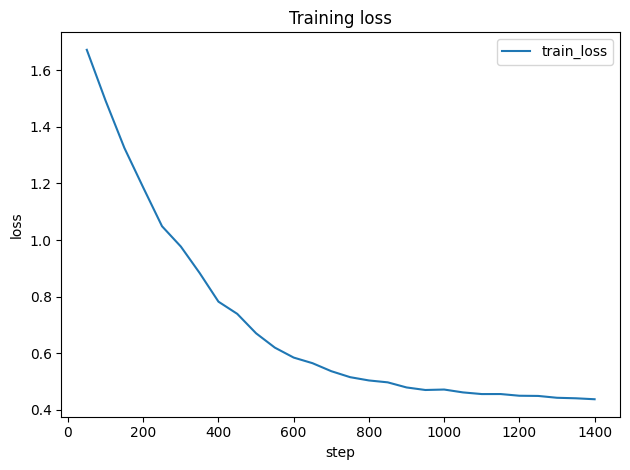

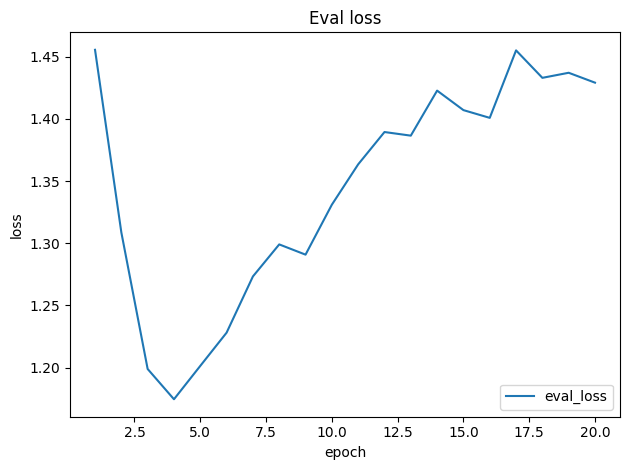

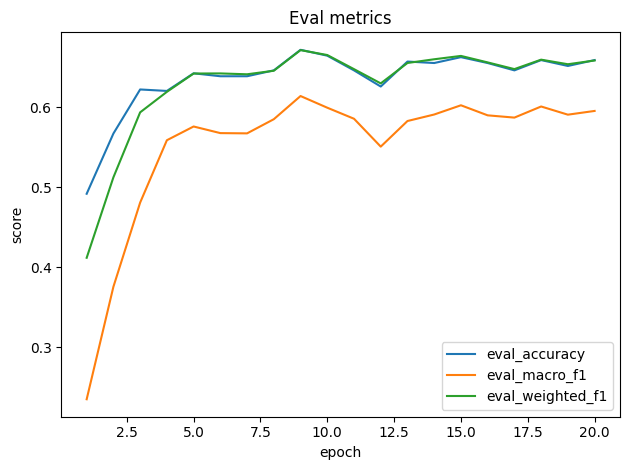

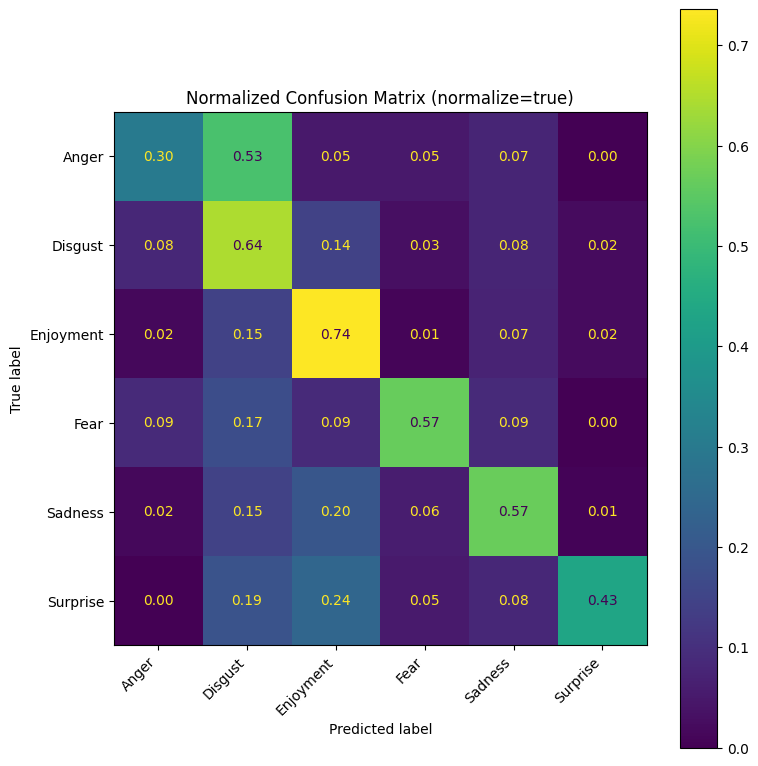

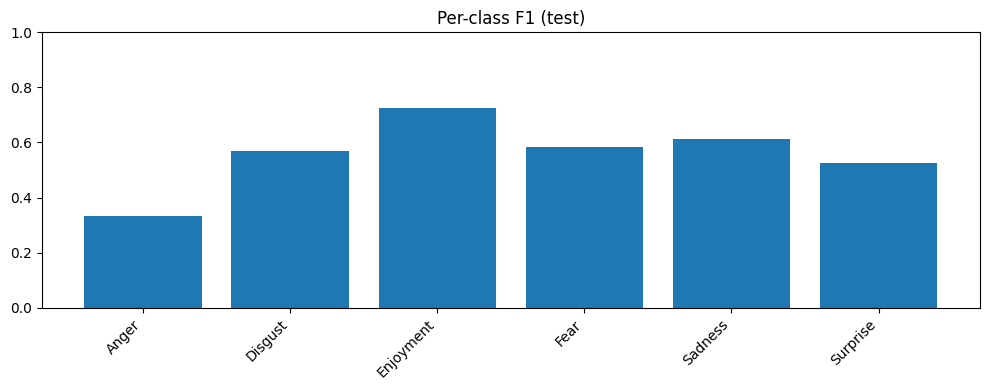

✅ Plots saved to: /kaggle/working/outputs_mbert_vsmec_no_other/plots


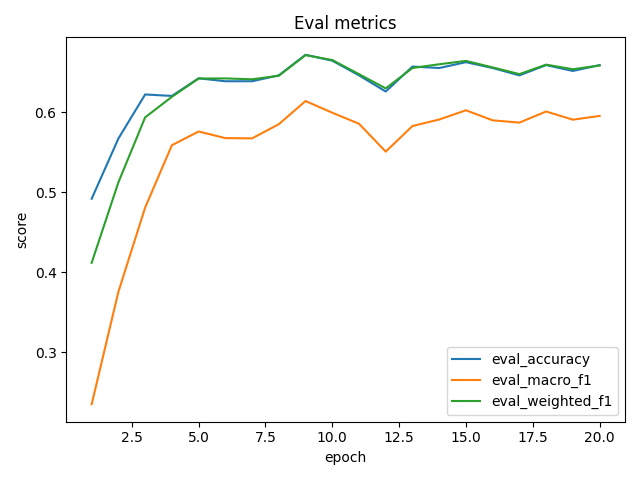

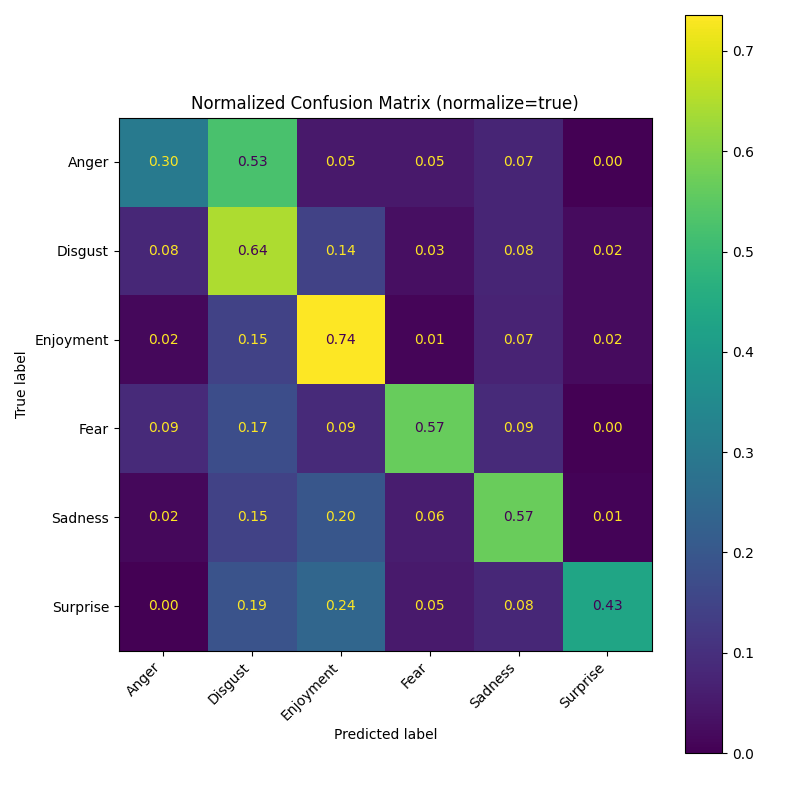

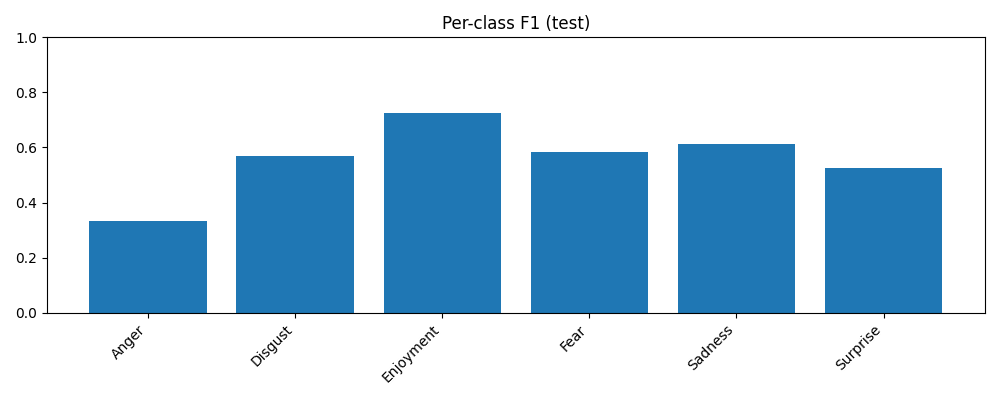

In [20]:
plot_curves(trainer.state.log_history, PLOTS_DIR)
plot_confmat_normalized(
    y_true, y_pred, label_list,
    os.path.join(PLOTS_DIR, "confmat_normalized_no_other_mbert.png")
)
plot_per_class_f1(
    y_true, y_pred, label_list,
    os.path.join(PLOTS_DIR, "per_class_f1_no_other_mbert.png")
)

print("✅ Plots saved to:", PLOTS_DIR)

from PIL import Image

display(Image.open(os.path.join(PLOTS_DIR, "eval_metrics.png")))
display(Image.open(os.path.join(PLOTS_DIR, "confmat_normalized_no_other_mbert.png")))
display(Image.open(os.path.join(PLOTS_DIR, "per_class_f1_no_other_mbert.png")))


In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
trainer.model.to(device)

demo = infer_mbert(
    "phấn chấn lên nào bro, ở đây có ae, không phải lo",
    trainer.model,
    tokenizer,
    id2label,
    max_length=MAX_LEN,
    device=device,
)
print(json.dumps(demo, ensure_ascii=False, indent=2))


{
  "input": "phấn chấn lên nào bro, ở đây có ae, không phải lo",
  "normalized": "phấn chấn lên nào bro, ở đây có ae, không phải lo",
  "pred_label": "Sadness",
  "probs": {
    "Anger": 0.028841013088822365,
    "Disgust": 0.26351815462112427,
    "Enjoyment": 0.025611616671085358,
    "Fear": 0.10979291051626205,
    "Sadness": 0.5130854845046997,
    "Surprise": 0.059150803834199905
  }
}
